<a href="https://colab.research.google.com/github/giyuntf2/1day1commit/blob/main/pytorch/Torch_CUDA_SimpleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

x = torch.FloatTensor([3.5])
x.type()

'torch.FloatTensor'

In [2]:
# cuda에 올리기
x = torch.cuda.FloatTensor([3.5])
x.type()

'torch.cuda.FloatTensor'

In [3]:
x.device

device(type='cuda', index=0)

# 600 x 600 CUDA Tensor Operation


In [4]:
import numpy as np

# 정사각형 행렬의 크기
size = 600

a = np.random.rand(size, size)
b = np.random.rand(size, size)

In [5]:
a_ = torch.cuda.FloatTensor(a)
b_ = torch.cuda.FloatTensor(b)

In [6]:
%%timeit

np.dot(a,b)

33.1 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit

a_mat_b = torch.matmul(a_, b_)

The slowest run took 11.91 times longer than the fastest. This could mean that an intermediate result is being cached.
23.3 µs ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# CUDA 선언 후 이를 확인하는 코드

In [8]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("Using cuda :", torch.cuda.get_device_name(0))

torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using cuda : Tesla P100-PCIE-16GB


device(type='cuda')

# GAN with 1010

In [9]:
import torch
import random
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

#실제 데이터에 대해서 1010 패턴을 반환하는 함수 제작.
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

def generate_real():
    real_data = torch.cuda.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)]
    )
    return real_data

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # 손실함수 생성
        self.loss_function = nn.MSELoss()

        # SGD 옵티마이저 생성
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망 출력 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [11]:
D = Discriminator()
"""
훈련 반복문 총 1만회.
판별기의 train()는 generate_real()에서 얻은 실제 데이터를 대상으로 훈련함.
목표 출력은 1.0의 값을 가진 텐서.
"""

for i in range(10000):
    D.train(generate_real(), torch.cuda.FloatTensor([1.0]))
    D.train(generate_random(4), torch.cuda.FloatTensor([0.0]))

counter =  10000
counter =  20000


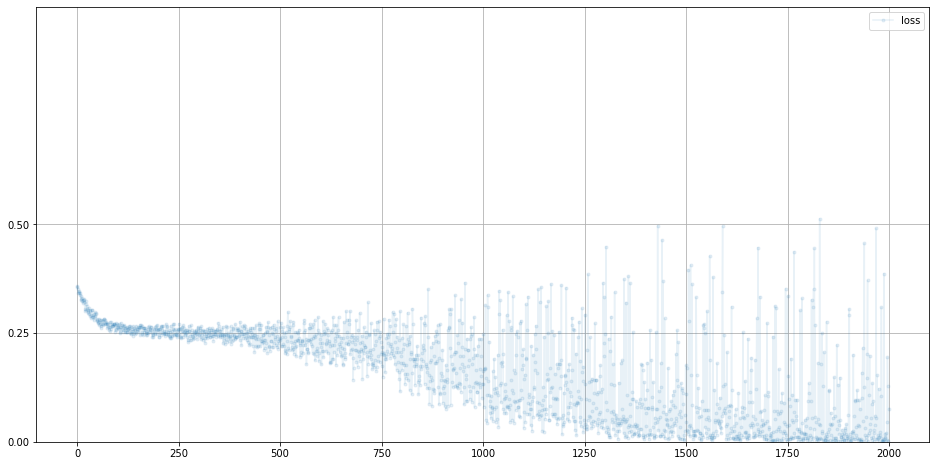

In [12]:
D.plot_progress()

In [13]:
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7826972007751465
0.09891863167285919


# 생성기 만들기

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)
#  
# """
# 입력값은 생성기의 신경망에 self.forward(inputs)로 전달된다.
# 생성기의 출력 g_output은 D.forward(g_output)을 통해 판별기의 신경망에 전달되고, 
# 분류 결과인 d_output이 나옴.
# """

    def train(self, D, inputs, targets):
        #신경망의 출력 계산
        g_output = self.forward(inputs)

        # 판별기로 전달
        d_output = D.forward(g_output)

        # 오차 계산
        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


In [15]:
G = Generator()

G.forward(torch.cuda.FloatTensor([0.5]))

tensor([0.4406, 0.4557, 0.4600, 0.5627], grad_fn=<SigmoidBackward0>)

In [19]:
%%time 

# 판별기 및 생성기 생성

D = Discriminator()
G = Generator()

image_list = []

# 판별기와 생성기 훈련

for i in range(10000):
    
    # 참일 경우 판별기 훈련
    D.train(generate_real(), torch.cuda.FloatTensor([1.0]))
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(torch.cuda.FloatTensor([0.5])).detach(), torch.cuda.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, torch.cuda.FloatTensor([0.5]), torch.cuda.FloatTensor([1.0]))
    
    # 매 1000 회마다 이미지 추가
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.cuda.FloatTensor([0.5])).detach().cpu().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 47 s, sys: 3.05 s, total: 50.1 s
Wall time: 50.6 s


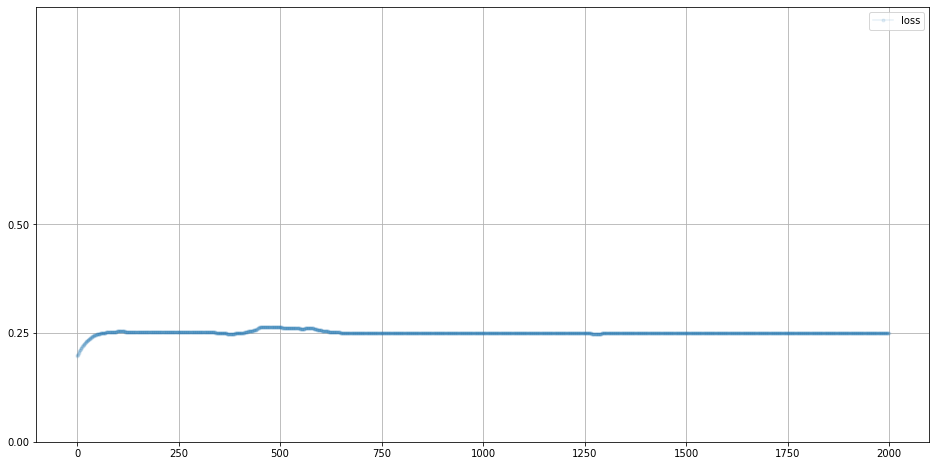

In [20]:
D.plot_progress()

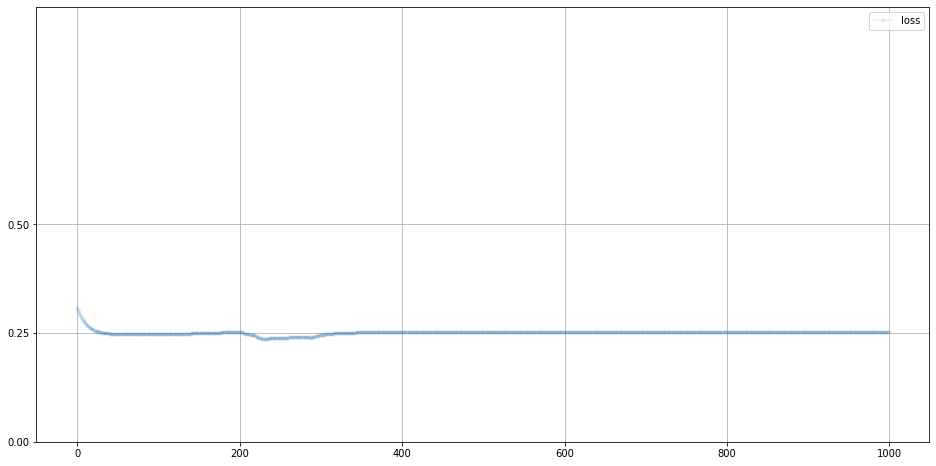

In [21]:
G.plot_progress()

In [25]:
G.forward(torch.cuda.FloatTensor([0.5]))

tensor([9.9988e-01, 9.9228e-01, 9.9994e-01, 1.6580e-04],
       grad_fn=<SigmoidBackward0>)

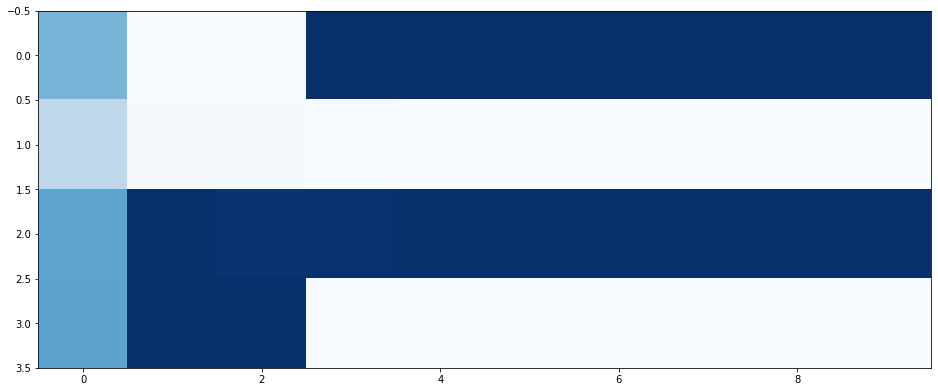

In [26]:
# 훈련시 패턴 시각화

plt.figure(figsize = (16,8))

plt.imshow(np.array(image_list).T, interpolation='none', cmap='Blues')